# Transaction Utility Theory

This notebook aims to recreate some of the empirical findings of Thaler, R. (1985). Mental accounting and consumer choice. Marketing Science, 4(3), 199-214. 
Specifically we are interested in whether LLMs' responses are similar to the original responses in **section 3** of the paper. 

<span style="color:red">
TBD: <br>
Show distribution of all experiment answers, or just $0, $5, $10 and label everything else as "others"?
</span>


---

In [252]:
from openai import OpenAI
import openai
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import replicate
from ast import literal_eval

In [71]:
# Get openAI API key (previously saved as environmental variable)
openai.api_key = os.environ["OPENAI_API_KEY"]

# Set client
client = OpenAI()

# Set global plot style
plt.style.use('seaborn-v0_8')

# Set plots to be displayed in notebook
%matplotlib inline

---

#### Setting up prompts for the experiment



- LLMs used in the experiment:
    - GPT-3.5-Turbo         (ID = 1)
    - GPT-4-1106-Preview    (ID = 2)
    - LLama-70b             (ID = 3)

We can differentiate between the following scenario combinations:

- Initial ticket price:
    - free                  (ID = 1)
    - $5 (as on ticket)     (ID = 2)
    - $10                   (ID = 3)
- Current market price:
    - $5                    (ID = 1)
    - $10                   (ID = 2)
- Selling to:
    - Friend                (ID = 1)
    - Stranger              (ID = 2)



Similar to the Prospect Theory and Decoy Effect notebooks, we will use experiment IDs to run the study. The IDs will be constructed as:

TU_model_initialprice_currentprice_buyer

Therefore, TU_2_2_1_2 would mean we used GPT-4-1106-Preview, an initial ticket price of $5, a current market price of $5 as well and we are selling to a stranger.

We leave out the information of the respondent being a student in all prompts. From experience, the more concise a prompt is, the better the answer quality. 
Since the job status/education level is not of interest here, we leave out this information in order to formulate clearer prompts. 

In [72]:
# Set up list of initial costs
initial_costs = ["but you were given your tickets for free by a friend.", "which is what you paid for each ticket.", "but you paid $10 each for your tickets when you bought them."]

# Set up list of current ticket prices
orientation_prices = ["$5", "$10"]

# Set up list of potential buyers in a scenario
potential_buyers = ["friend?", "stranger?"]

- Constructing the prompts

In [73]:
TU_prompts = []
for costs in initial_costs:
    for orientation_price in orientation_prices:
        for potential_buyer in potential_buyers:
            prompt = f"""Imagine that you are going to a soldout Cornell hockey playoff game, and you have an extra ticket to sell or give away. The price marked on the ticket is $5 {costs}
            You get to the game early to make sure you get rid of the ticket. An informal survey of people selling tickets indicates that the going price is {orientation_price}. 
            You find someone who wants the ticket and takes out his wallet to pay you. He asks, how much you want for the ticket. 
            Assume that there is now law against charging a price higher than that marked on the ticket. What price do you ask for, if he is a {potential_buyer}"""
            TU_prompts.append(prompt)

- TU_prompts[0]: free, $5, friend  -> 1_1_1 (Configuration 1)
- TU_prompts[1]: free, $5, stranger -> 1_1_2 (Configuration 2)
- TU_prompts[2]: free, $10, friend -> 1_2_1 (Configuration 3)
- TU_prompts[3]: free, $10, stranger -> 1_2_2 (Configuration 4)
- TU_prompts[4]: $5, $5, friend -> 2_1_1 (Configuration 5)
- TU_prompts[5]: $5, $5, stranger -> 2_1_2 (Configuration 6)
- TU_prompts[6]: $5, $10, friend -> 2_2_1 (Configuration 7)
- TU_prompts[7]: $5, $10, stranger -> 2_2_2 (Configuration 8)
- TU_prompts[8]: $10, $5, friend -> 3_1_1  (Configuration 9)
- TU_prompts[9]: $10, $5, stranger -> 3_1_2 (Configuration 10)
- TU_prompts[10]: $10, $10, friend -> 3_2_1 (Configuration 11)
- TU_prompts[11]: $10, $10, stranger -> 3_2_2 (Configuration 12)

The results of the original experiment are:


| Configuration   | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11   | 12   |
|------------------|------|------|------|------|------|------|------|------|------|------|------|------|
| $0              | 68%  | 6%   | 65%  | 6%   | 14%  | 0%   | 7%   | 0%   | 0%   | 0%   | 0%   | 0%   |
| $5              | 26%  | 77%  | 26%  | 16%  | 79%  | 79%  | 79%  | 14%  | 69%  | 42%  | 15%  | 0%   |
| $10             | 3%   | 10%  | 6%   | 58%  | 0%   | 7%   | 4%   | 57%  | 23%  | 46%  | 69%  | 73%  |
| Other          | 6%   | 6%   | 3%   | 19%  | 7%   | 14%  | 9%   | 29%  | 8%   | 12%  | 15%  | 27%  |
| N              | 31   | 31   | 31   | 31   | 28   | 28   | 28   | 28   | 26   | 26   | 26   | 26   |



In [74]:
og_results = {
    "og_results_1" : [68, 26, 3, 6],
    "og_results_2" : [6, 77, 10, 6],
    "og_results_3" : [65, 26, 6, 3],
    "og_results_4" : [6, 16, 58, 19],
    "og_results_5" : [14, 79, 7, 14],
    "og_results_6" : [0, 79, 7, 14],
    "og_results_7" : [7, 79, 4, 9],
    "og_results_8" : [0, 14, 57, 29],
    "og_results_9" : [0, 69, 23, 8],
    "og_results_10" : [0, 42, 46, 12],
    "og_results_11" : [0, 15, 69, 15],
    "og_results_12" : [0, 0, 73, 27]
}

- Setting up instructions the model should abide by

In [75]:
instructions = "Answer by only giving a single price in dollars and cents without an explanation."

In [ ]:
# Gather all experiment IDs
experiment_ids =  ["TU_1_1_1_1", "TU_1_1_1_2", "TU_1_1_2_1", "TU_1_1_2_2", "TU_1_2_1_1", "TU_1_2_1_2", "TU_1_2_2_1", "TU_1_2_2_2", "TU_1_3_1_1", "TU_1_3_1_2", "TU_1_3_2_1", "TU_1_3_2_2",
                   "TU_2_1_1_1", "TU_2_1_1_2", "TU_2_1_2_1", "TU_2_1_2_2", "TU_2_2_1_1", "TU_2_2_1_2", "TU_2_2_2_1", "TU_2_2_2_2", "TU_2_3_1_1", "TU_2_3_1_2", "TU_2_3_2_1", "TU_2_3_2_2",
                   "TU_3_1_1_1", "TU_3_1_1_2", "TU_3_1_2_1", "TU_3_1_2_2", "TU_3_2_1_1", "TU_3_2_1_2", "TU_3_2_2_1", "TU_3_2_2_2", "TU_3_3_1_1", "TU_3_3_1_2", "TU_3_3_2_1", "TU_3_3_2_2"]

---

#### Dictionaries to extract information about the different experiments

In [363]:
# Dictionary to look up prompt for a given experiment id. key: experiment id, value: prompt
TU_experiment_prompts_dict = {
    "TU_1_1_1_1": TU_prompts[0],
    "TU_1_1_1_2": TU_prompts[1],
    "TU_1_1_2_1": TU_prompts[2],
    "TU_1_1_2_2": TU_prompts[3],
    "TU_1_2_1_1": TU_prompts[4],
    "TU_1_2_1_2": TU_prompts[5],
    "TU_1_2_2_1": TU_prompts[6],
    "TU_1_2_2_2": TU_prompts[7],
    "TU_1_3_1_1": TU_prompts[8],
    "TU_1_3_1_2": TU_prompts[9],
    "TU_1_3_2_1": TU_prompts[10],
    "TU_1_3_2_2": TU_prompts[11],
    "TU_2_1_1_1": TU_prompts[0],
    "TU_2_1_1_2": TU_prompts[1],
    "TU_2_1_2_1": TU_prompts[2],
    "TU_2_1_2_2": TU_prompts[3],
    "TU_2_2_1_1": TU_prompts[4],
    "TU_2_2_1_2": TU_prompts[5],
    "TU_2_2_2_1": TU_prompts[6],
    "TU_2_2_2_2": TU_prompts[7],
    "TU_2_3_1_1": TU_prompts[8],
    "TU_2_3_1_2": TU_prompts[9],
    "TU_2_3_2_1": TU_prompts[10],
    "TU_2_3_2_2": TU_prompts[11],
    "TU_3_1_1_1": TU_prompts[0],
    "TU_3_1_1_2": TU_prompts[1],
    "TU_3_1_2_1": TU_prompts[2],
    "TU_3_1_2_2": TU_prompts[3],
    "TU_3_2_1_1": TU_prompts[4],
    "TU_3_2_1_2": TU_prompts[5],
    "TU_3_2_2_1": TU_prompts[6],
    "TU_3_2_2_2": TU_prompts[7],
    "TU_3_3_1_1": TU_prompts[8],
    "TU_3_3_1_2": TU_prompts[9],
    "TU_3_3_2_1": TU_prompts[10],
    "TU_3_3_2_2": TU_prompts[11],
}

# Dictionary to look up which model to use for a given experiment id. key: experiment id, value: model name
TU_model_dict = {
    "TU_1_1_1_1": "gpt-3.5-turbo",
    "TU_1_1_1_2": "gpt-3.5-turbo",
    "TU_1_1_2_1": "gpt-3.5-turbo",
    "TU_1_1_2_2": "gpt-3.5-turbo",
    "TU_1_2_1_1": "gpt-3.5-turbo",
    "TU_1_2_1_2": "gpt-3.5-turbo",
    "TU_1_2_2_1": "gpt-3.5-turbo",
    "TU_1_2_2_2": "gpt-3.5-turbo",
    "TU_1_3_1_1": "gpt-3.5-turbo",
    "TU_1_3_1_2": "gpt-3.5-turbo",
    "TU_1_3_2_1": "gpt-3.5-turbo",
    "TU_1_3_2_2": "gpt-3.5-turbo",
    "TU_2_1_1_1": "gpt-4-1106-preview",
    "TU_2_1_1_2": "gpt-4-1106-preview",
    "TU_2_1_2_1": "gpt-4-1106-preview",
    "TU_2_1_2_2": "gpt-4-1106-preview",
    "TU_2_2_1_1": "gpt-4-1106-preview",
    "TU_2_2_1_2": "gpt-4-1106-preview",
    "TU_2_2_2_1": "gpt-4-1106-preview",
    "TU_2_2_2_2": "gpt-4-1106-preview",
    "TU_2_3_1_1": "gpt-4-1106-preview",
    "TU_2_3_1_2": "gpt-4-1106-preview",
    "TU_2_3_2_1": "gpt-4-1106-preview",
    "TU_2_3_2_2": "gpt-4-1106-preview",
    "TU_3_1_1_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_1_1_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_1_2_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_1_2_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_2_1_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_2_1_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_2_2_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_2_2_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_3_1_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_3_1_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_3_2_1": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "TU_3_3_2_2": "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
}

# Dictionary to look up what prompt was used for a given experiment id. key: experiment id, value: prompt variable name
TU_prompt_ids_dict = {
    "TU_1_1_1_1": "TU_prompts[0]",
    "TU_1_1_1_2": "TU_prompts[1]",
    "TU_1_1_2_1": "TU_prompts[2]",
    "TU_1_1_2_2": "TU_prompts[3]",
    "TU_1_2_1_1": "TU_prompts[4]",
    "TU_1_2_1_2": "TU_prompts[5]",
    "TU_1_2_2_1": "TU_prompts[6]",
    "TU_1_2_2_2": "TU_prompts[7]",
    "TU_1_3_1_1": "TU_prompts[8]",
    "TU_1_3_1_2": "TU_prompts[9]",
    "TU_1_3_2_1": "TU_prompts[10]",
    "TU_1_3_2_2": "TU_prompts[11]",
    "TU_2_1_1_1": "TU_prompts[0]",
    "TU_2_1_1_2": "TU_prompts[1]",
    "TU_2_1_2_1": "TU_prompts[2]",
    "TU_2_1_2_2": "TU_prompts[3]",
    "TU_2_2_1_1": "TU_prompts[4]",
    "TU_2_2_1_2": "TU_prompts[5]",
    "TU_2_2_2_1": "TU_prompts[6]",
    "TU_2_2_2_2": "TU_prompts[7]",
    "TU_2_3_1_1": "TU_prompts[8]",
    "TU_2_3_1_2": "TU_prompts[9]",
    "TU_2_3_2_1": "TU_prompts[10]",
    "TU_2_3_2_2": "TU_prompts[11]",
    "TU_3_1_1_1": "TU_prompts[0]",
    "TU_3_1_1_2": "TU_prompts[1]",
    "TU_3_1_2_1": "TU_prompts[2]",
    "TU_3_1_2_2": "TU_prompts[3]",
    "TU_3_2_1_1": "TU_prompts[4]",
    "TU_3_2_1_2": "TU_prompts[5]",
    "TU_3_2_2_1": "TU_prompts[6]",
    "TU_3_2_2_2": "TU_prompts[7]",
    "TU_3_3_1_1": "TU_prompts[8]",
    "TU_3_3_1_2": "TU_prompts[9]",
    "TU_3_3_2_1": "TU_prompts[10]",
    "TU_3_3_2_2": "TU_prompts[11]",
    }

# Dictionary to look up initital ticket cotsts for a given experiment id. key: experiment id, value: initial costs
TU_initial_costs_dict = {
    "TU_1_1_1_1": 0,
    "TU_1_1_1_2": 0,
    "TU_1_1_2_1": 0,
    "TU_1_1_2_2": 0,
    "TU_1_2_1_1": 5,
    "TU_1_2_1_2": 5,
    "TU_1_2_2_1": 5,
    "TU_1_2_2_2": 5,
    "TU_1_3_1_1": 10,
    "TU_1_3_1_2": 10,
    "TU_1_3_2_1": 10,
    "TU_1_3_2_2": 10,
    "TU_2_1_1_1": 0,
    "TU_2_1_1_2": 0,
    "TU_2_1_2_1": 0,
    "TU_2_1_2_2": 0,
    "TU_2_2_1_1": 5,
    "TU_2_2_1_2": 5,
    "TU_2_2_2_1": 5,
    "TU_2_2_2_2": 5,
    "TU_2_3_1_1": 10,
    "TU_2_3_1_2": 10,
    "TU_2_3_2_1": 10,
    "TU_2_3_2_2": 10,
    "TU_3_1_1_1": 0,
    "TU_3_1_1_2": 0,
    "TU_3_1_2_1": 0,
    "TU_3_1_2_2": 0,
    "TU_3_2_1_1": 5,
    "TU_3_2_1_2": 5,
    "TU_3_2_2_1": 5,
    "TU_3_2_2_2": 5,
    "TU_3_3_1_1": 10,
    "TU_3_3_1_2": 10,
    "TU_3_3_2_1": 10,
    "TU_3_3_2_2": 10,
    }

# Dictionary to look up orientation prices for a given experiment id. key: experiment id, value: orientation price
TU_orientation_prices_dict = {
    "TU_1_1_1_1": 5,
    "TU_1_1_1_2": 5,
    "TU_1_1_2_1": 10,
    "TU_1_1_2_2": 10,
    "TU_1_2_1_1": 5,
    "TU_1_2_1_2": 5,
    "TU_1_2_2_1": 10,
    "TU_1_2_2_2": 10,
    "TU_1_3_1_1": 5,
    "TU_1_3_1_2": 5,
    "TU_1_3_2_1": 10,
    "TU_1_3_2_2": 10,
    "TU_2_1_1_1": 5,
    "TU_2_1_1_2": 5,
    "TU_2_1_2_1": 10,
    "TU_2_1_2_2": 10,
    "TU_2_2_1_1": 5,
    "TU_2_2_1_2": 5,
    "TU_2_2_2_1": 10,
    "TU_2_2_2_2": 10,
    "TU_2_3_1_1": 5,
    "TU_2_3_1_2": 5,
    "TU_2_3_2_1": 10,
    "TU_2_3_2_2": 10,
    "TU_3_1_1_1": 5,
    "TU_3_1_1_2": 5,
    "TU_3_1_2_1": 10,
    "TU_3_1_2_2": 10,
    "TU_3_2_1_1": 5,
    "TU_3_2_1_2": 5,
    "TU_3_2_2_1": 10,
    "TU_3_2_2_2": 10,
    "TU_3_3_1_1": 5,
    "TU_3_3_1_2": 5,
    "TU_3_3_2_1": 10,
    "TU_3_3_2_2": 10,
    }   

# Dictionary to look up potential buyers for a given experiment id. key: experiment id, value: potential buyer
TU_buyers_dict = {
    "TU_1_1_1_1": "friend",
    "TU_1_1_1_2": "stranger",
    "TU_1_1_2_1": "friend",
    "TU_1_1_2_2": "stranger",
    "TU_1_2_1_1": "friend",
    "TU_1_2_1_2": "stranger",
    "TU_1_2_2_1": "friend",
    "TU_1_2_2_2": "stranger",
    "TU_1_3_1_1": "friend",
    "TU_1_3_1_2": "stranger",
    "TU_1_3_2_1": "friend",
    "TU_1_3_2_2": "stranger",
    "TU_2_1_1_1": "friend",
    "TU_2_1_1_2": "stranger",
    "TU_2_1_2_1": "friend",
    "TU_2_1_2_2": "stranger",
    "TU_2_2_1_1": "friend",
    "TU_2_2_1_2": "stranger",
    "TU_2_2_2_1": "friend",
    "TU_2_2_2_2": "stranger",
    "TU_2_3_1_1": "friend",
    "TU_2_3_1_2": "stranger",
    "TU_2_3_2_1": "friend",
    "TU_2_3_2_2": "stranger",
    "TU_3_1_1_1": "friend",
    "TU_3_1_1_2": "stranger",
    "TU_3_1_2_1": "friend",
    "TU_3_1_2_2": "stranger",
    "TU_3_2_1_1": "friend",
    "TU_3_2_1_2": "stranger",
    "TU_3_2_2_1": "friend",
    "TU_3_2_2_2": "stranger",
    "TU_3_3_1_1": "friend",
    "TU_3_3_1_2": "stranger",
    "TU_3_3_2_1": "friend",
    "TU_3_3_2_2": "stranger",
}

# Dictionary to look up original results for a given experiment id. key: experiment id, value: original results
TU_results_dict = {
    "TU_1_1_1_1": [68, 26, 3, 6],
    "TU_1_1_1_2": [6, 77, 10, 6],
    "TU_1_1_2_1": [65, 26, 6, 3],
    "TU_1_1_2_2": [6, 16, 58, 19],
    "TU_1_2_1_1": [14, 79, 7, 14],
    "TU_1_2_1_2": [0, 79, 7, 14],
    "TU_1_2_2_1": [7, 79, 4, 9],
    "TU_1_2_2_2": [0, 14, 57, 29],
    "TU_1_3_1_1": [0, 69, 23, 8],
    "TU_1_3_1_2": [0, 42, 46, 12],
    "TU_1_3_2_1": [0, 15, 69, 15],
    "TU_1_3_2_2": [0, 0, 73, 27],
    "TU_2_1_1_1": [68, 26, 3, 6],
    "TU_2_1_1_2": [6, 77, 10, 6],
    "TU_2_1_2_1": [65, 26, 6, 3],
    "TU_2_1_2_2": [6, 16, 58, 19],
    "TU_2_2_1_1": [14, 79, 7, 14],
    "TU_2_2_1_2": [0, 79, 7, 14],
    "TU_2_2_2_1": [7, 79, 4, 9],
    "TU_2_2_2_2": [0, 14, 57, 29],
    "TU_2_3_1_1": [0, 69, 23, 8],
    "TU_2_3_1_2": [0, 42, 46, 12],
    "TU_2_3_2_1": [0, 15, 69, 15],
    "TU_2_3_2_2": [0, 0, 73, 27],
    "TU_3_1_1_1": [68, 26, 3, 6],
    "TU_3_1_1_2": [6, 77, 10, 6],
    "TU_3_1_2_1": [65, 26, 6, 3],
    "TU_3_1_2_2": [6, 16, 58, 19],
    "TU_3_2_1_1": [14, 79, 7, 14],
    "TU_3_2_1_2": [0, 79, 7, 14],
    "TU_3_2_2_1": [7, 79, 4, 9],
    "TU_3_2_2_2": [0, 14, 57, 29],
    "TU_3_3_1_1": [0, 69, 23, 8],
    "TU_3_3_1_2": [0, 42, 46, 12],
    "TU_3_3_2_1": [0, 15, 69, 15],
    "TU_3_3_2_2": [0, 0, 73, 27],
}

# Dictionary to look configuration given experiment id. key: experiment id, value: configuration (0-12)
TU_configurations_dict = {
    "TU_1_1_1_1": 1,
    "TU_1_1_1_2": 2,
    "TU_1_1_2_1": 3,
    "TU_1_1_2_2": 4,
    "TU_1_2_1_1": 5,
    "TU_1_2_1_2": 6,
    "TU_1_2_2_1": 7,
    "TU_1_2_2_2": 8,
    "TU_1_3_1_1": 9,
    "TU_1_3_1_2": 10,
    "TU_1_3_2_1": 11,
    "TU_1_3_2_2": 12,
    "TU_2_1_1_1": 1,
    "TU_2_1_1_2": 2,
    "TU_2_1_2_1": 3,
    "TU_2_1_2_2": 4,
    "TU_2_2_1_1": 5,
    "TU_2_2_1_2": 6,
    "TU_2_2_2_1": 7,
    "TU_2_2_2_2": 8,
    "TU_2_3_1_1": 9,
    "TU_2_3_1_2": 10,
    "TU_2_3_2_1": 11,
    "TU_2_3_2_2": 12,
    "TU_3_1_1_1": 1,
    "TU_3_1_1_2": 2,
    "TU_3_1_2_1": 3,
    "TU_3_1_2_2": 4,
    "TU_3_2_1_1": 5,
    "TU_3_2_1_2": 6,
    "TU_3_2_2_1": 7,
    "TU_3_2_2_2": 8,
    "TU_3_3_1_1": 9,
    "TU_3_3_1_2": 10,
    "TU_3_3_2_1": 11,
    "TU_3_3_2_2": 10
}

# Dictionary to look up experiment id as string for a given experiment id. key: experiment id, value: experiment id as string
TU_experiment_ids_dict = {
    "TU_1_1_1_1": "TU_1_1_1_1",
    "TU_1_1_1_2": "TU_1_1_1_2",
    "TU_1_1_2_1": "TU_1_1_2_1",
    "TU_1_1_2_2": "TU_1_1_2_2",
    "TU_1_2_1_1": "TU_1_2_1_1",
    "TU_1_2_1_2": "TU_1_2_1_2",
    "TU_1_2_2_1": "TU_1_2_2_1",
    "TU_1_2_2_2": "TU_1_2_2_2",
    "TU_1_3_1_1": "TU_1_3_1_1",
    "TU_1_3_1_2": "TU_1_3_1_2",
    "TU_1_3_2_1": "TU_1_3_2_1",
    "TU_1_3_2_2": "TU_1_3_2_2",
    "TU_2_1_1_1": "TU_2_1_1_1",
    "TU_2_1_1_2": "TU_2_1_1_2",
    "TU_2_1_2_1": "TU_2_1_2_1",
    "TU_2_1_2_2": "TU_2_1_2_2",
    "TU_2_2_1_1": "TU_2_2_1_1",
    "TU_2_2_1_2": "TU_2_2_1_2",
    "TU_2_2_2_1": "TU_2_2_2_1",
    "TU_2_2_2_2": "TU_2_2_2_2",
    "TU_2_3_1_1": "TU_2_3_1_1",
    "TU_2_3_1_2": "TU_2_3_1_2",
    "TU_2_3_2_1": "TU_2_3_2_1",
    "TU_2_3_2_2": "TU_2_3_2_2",
    "TU_3_1_1_1": "TU_3_1_1_1",
    "TU_3_1_1_2": "TU_3_1_1_2",
    "TU_3_1_2_1": "TU_3_1_2_1",
    "TU_3_1_2_2": "TU_3_1_2_2",
    "TU_3_2_1_1": "TU_3_2_1_1",
    "TU_3_2_1_2": "TU_3_2_1_2",
    "TU_3_2_2_1": "TU_3_2_2_1",
    "TU_3_2_2_2": "TU_3_2_2_2",
    "TU_3_3_1_1": "TU_3_3_1_1",
    "TU_3_3_1_2": "TU_3_3_1_2",
    "TU_3_3_2_1": "TU_3_3_2_1",
    "TU_3_3_2_2": "TU_3_3_2_2",
}


---

#### Setting up functions to repeatedly prompt the LLMs

- Helper function to extract dollar amount of given answers

In [77]:
# Function to extract the dollar amount of the answer from LLMs
def extract_dollar_amounts(answers):
    # Only return values that start with "$"
    valid_prices = [item for item in answers if item.startswith("$")]
    # Delete the "$" from the beginning of each price
    prices = [item.replace('$', '') for item in valid_prices]
    return prices

- Functions to query 1 prompt n times for OpenAI Models

In [78]:
def TU_run_experiment(experiment_id, n, progress_bar, temperature):
    
    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = TU_model_dict[experiment_id], 
            max_tokens = 2,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "system", "content": "Answer by only giving a single price in dollars and cents without an explanation."},        
            {"role": "user", "content": 
             f"{TU_experiment_prompts_dict[experiment_id]} Answer by only giving a single price in dollars and cents without an explanation."}
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
        # Update progress bar (given from either temperature loop, or set locally)
        progress_bar.update(1)

    # Extract valid prices from answers
    valid_prices = extract_dollar_amounts(answers)

    # Compute number of valid answers
    n_observations = len(valid_prices)

    # Collect results 
    results = [experiment_id, temperature, TU_model_dict[experiment_id], TU_initial_costs_dict[experiment_id], TU_orientation_prices_dict[experiment_id],
                TU_buyers_dict[experiment_id], answers, n_observations, TU_configurations_dict[experiment_id], TU_results_dict[experiment_id]]

    # Give out results
    return results

- Adjusted function for dashboard  (returns dataframe right away)

In [79]:
def TU_run_experiment_dashboard(experiment_id, n, progress_bar, temperature):
    
    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = TU_model_dict[experiment_id], 
            max_tokens = 2,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "system", "content": "Answer by only giving a single price in dollars and cents without an explanation."},        
            {"role": "user", "content": 
             f"{TU_experiment_prompts_dict[experiment_id]} Answer by only giving a single price in dollars and cents without an explanation."}
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
        # Update progress bar (given from either temperature loop, or set locally)
        progress_bar.update(1)

    # Extract valid prices from answers
    valid_prices = extract_dollar_amounts(answers)

    # Compute number of valid answers
    n_observations = len(valid_prices)

    # Collect results 
    results = [experiment_id, temperature, TU_model_dict[experiment_id], TU_initial_costs_dict[experiment_id], TU_orientation_prices_dict[experiment_id],
                TU_buyers_dict[experiment_id], answers, n_observations, TU_configurations_dict[experiment_id], TU_results_dict[experiment_id]]
    # Set index
    results = pd.DataFrame(results).set_index(pd.Index(
        ["experiment_id", "temperature", "model", "initial_cost", "orientation_price", "buyer", "answers", "Obs.", "configuration", "original"]))
    # Give out results
    return results

- Functions to query 1 prompt n times (LLama)

In [80]:
def TU_run_experiment_llama(experiment_id, n, progress_bar, temperature):
    answers = []
    for _ in range(n):
        response = replicate.run(
            TU_model_dict[experiment_id],
            input = {
                "system_prompt":  "Answer by only giving a single price in dollars and cents without an explanation.",
                "temperature": temperature,
                "max_new_tokens": 5, 
                "prompt": f"{TU_experiment_prompts_dict[experiment_id]} Answer by only giving a single price in dollars and cents without an explanation."
            }
        )
        # Grab answer and append to list
        answer = "" # Set to empty string, otherwise it would append the previous answer to the new one
        for item in response:
            answer = answer + item
        answers.append(answer.strip())

        # Update progress bar
        progress_bar.update(1)

    
    # Extract valid prices from answers
    valid_prices = extract_dollar_amounts(answers)

    # Compute number of valid answers
    n_observations = len(valid_prices)

    # Collect results 
    results = [experiment_id, temperature, TU_model_dict[experiment_id], TU_initial_costs_dict[experiment_id], TU_orientation_prices_dict[experiment_id],
               TU_buyers_dict[experiment_id], answers, n_observations, TU_configurations_dict[experiment_id], TU_results_dict[experiment_id]]
    
    # Give out results
    return results

- Adjusted function for dashboard (returns dataframe right away)

In [81]:
def TU_run_experiment_llama_dashboard(experiment_id, n, progress_bar, temperature):
    answers = []
    for _ in range(n):
        response = replicate.run(
            TU_model_dict[experiment_id],
            input = {
                "system_prompt":  "Answer by only giving a single price in dollars and cents without an explanation.",
                "temperature": temperature,
                "max_new_tokens": 5, 
                "prompt": f"{TU_experiment_prompts_dict[experiment_id]} Answer by only giving a single price in dollars and cents without an explanation."
            }
        )
        # Grab answer and append to list
        answer = "" # Set to empty string, otherwise it would append the previous answer to the new one
        for item in response:
            answer = answer + item
        answers.append(answer.strip())

        # Update progress bar
        progress_bar.update(1)

    
    # Extract valid prices from answers
    valid_prices = extract_dollar_amounts(answers)

    # Compute number of valid answers
    n_observations = len(valid_prices)

    # Collect results 
    results = [experiment_id, temperature, TU_model_dict[experiment_id], TU_initial_costs_dict[experiment_id], TU_orientation_prices_dict[experiment_id],
               TU_buyers_dict[experiment_id], answers, n_observations, TU_configurations_dict[experiment_id], TU_results_dict[experiment_id]]
    # Set index
    results = pd.DataFrame(results).set_index(pd.Index(
        ["experiment_id", "temperature", "model", "initial_cost", "orientation_price", "buyer", "answers", "Obs.", "configuration", "original"]))
    
    # Give out results
    return results

- Function to loop run_experiment() over a list of temperature values

In [82]:
def TU_temperature_loop(function, experiment_id, temperature_list = [0.5, 1, 1.5], n = 50):
    """
    Function to run an experiment with different temperature values.
    
    Args:
        function (function): Function to be used for querying ChatGPT i.e. run_experiment()
        experiment_id (str): ID of th e experiment to be run. Contains info about prompt and model
        temperature_list (list): List of temperature values to be looped over
        n: Number of requests for each prompt per temperature value
        max_tokens: Maximum number of tokens in response object
        
    Returns:
        results_df: Dataframe with experiment results
        probs_df: Dataframe with answer probabilities
    """    
    # Empty list for storing results
    results_list = []

    # Initialize progress bar -> used as input for run_experiment()
    progress_bar = tqdm(range(n*len(temperature_list)))

    # Loop over different temperature values, calling the input function n times each (i.e. queriyng ChatGPT n times)
    for temperature in temperature_list:
        results = function(experiment_id = experiment_id, n = n, temperature = temperature, progress_bar = progress_bar) 
        results_list.append(results)
       

    # Horizontally concatenate the results, transpose, and set index
    results_df = pd.DataFrame(results_list).transpose().set_index(pd.Index(
        ["experiment_id", "temperature", "model", "initial_cost", "orientation_price", "buyer", "answers", "Obs.", "configuration", "original"]))
  
   
    # Return some information about the experiment as a check
    check = f"In this run, a total of {n*len(temperature_list)} requests were made using {TU_prompt_ids_dict[experiment_id]}."
    # Print information about the experiment
    print(check)
 

    return results_df

---

### Model 1: GPT-3.5-Turbo

In [83]:
# For GPT-3.5-turbo we make 100 requests per prompt & temperature value
# Also, we will focus on lower temperature values to get more consise answers. For higher temperature values, the 
# answers almost always contain the same information, but come with an unnecessary explanation (e.g. "I would ask for $10, because that is the price that everyone else is asking for.")
N = 100

- Configuration 1

In [12]:
results_1 = []
results_1_1 = TU_temperature_loop(TU_run_experiment, "TU_1_1_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_1.append(results_1_1)

  0%|          | 1/300 [00:00<02:08,  2.34it/s]

100%|██████████| 300/300 [02:12<00:00,  2.26it/s]

In this run, a total of 300 requests were made using TU_prompts[0].


- Configuration 2

In [20]:
results_2 = []
results_2_1 = TU_temperature_loop(TU_run_experiment, "TU_1_1_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_2.append(results_2_1)

100%|██████████| 300/300 [02:09<00:00,  2.31it/s]

In this run, a total of 300 requests were made using TU_prompts[1].


- Configuration 3

In [21]:
results_3 = []
results_3_1 = TU_temperature_loop(TU_run_experiment, "TU_1_1_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_3.append(results_3_1)

100%|██████████| 300/300 [02:43<00:00,  1.84it/s]

In this run, a total of 300 requests were made using TU_prompts[2].


- Configuration 4

In [22]:
results_4 = []
results_4_1 = TU_temperature_loop(TU_run_experiment, "TU_1_1_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_4.append(results_4_1)

100%|██████████| 300/300 [02:15<00:00,  2.21it/s]

In this run, a total of 300 requests were made using TU_prompts[3].


- Configuration 5

In [23]:
results_5 = []
results_5_1 = TU_temperature_loop(TU_run_experiment, "TU_1_2_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_5.append(results_5_1)

100%|██████████| 300/300 [03:21<00:00,  1.49it/s]

In this run, a total of 300 requests were made using TU_prompts[4].


- Configuration 6

In [24]:
results_6 = []
results_6_1 = TU_temperature_loop(TU_run_experiment, "TU_1_2_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_6.append(results_6_1)

100%|██████████| 300/300 [02:19<00:00,  2.14it/s]

In this run, a total of 300 requests were made using TU_prompts[5].


- Configuration 7

In [25]:
results_7 = []
results_7_1 = TU_temperature_loop(TU_run_experiment, "TU_1_2_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_7.append(results_7_1)

100%|██████████| 300/300 [02:13<00:00,  2.25it/s]

In this run, a total of 300 requests were made using TU_prompts[6].


- Configuration 8

In [26]:
results_8 = []
results_8_1 = TU_temperature_loop(TU_run_experiment, "TU_1_2_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_8.append(results_8_1)

100%|██████████| 300/300 [02:20<00:00,  2.13it/s]

In this run, a total of 300 requests were made using TU_prompts[7].


- Configuration 9

In [27]:
results_9 = []
results_9_1 = TU_temperature_loop(TU_run_experiment, "TU_1_3_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_9.append(results_9_1)

100%|██████████| 300/300 [02:58<00:00,  1.69it/s]

In this run, a total of 300 requests were made using TU_prompts[8].


- Configuration 10

In [28]:
results_10 = []
results_10_1 = TU_temperature_loop(TU_run_experiment, "TU_1_3_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_10.append(results_10_1)

100%|██████████| 300/300 [03:04<00:00,  1.63it/s]

In this run, a total of 300 requests were made using TU_prompts[9].


- Configuration 11

In [29]:
results_11 = []
results_11_1 = TU_temperature_loop(TU_run_experiment, "TU_1_3_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_11.append(results_11_1)

100%|██████████| 300/300 [03:13<00:00,  1.55it/s]

In this run, a total of 300 requests were made using TU_prompts[10].


- Configuration 12

In [30]:
results_12 = []
results_12_1 = TU_temperature_loop(TU_run_experiment, "TU_1_3_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_12.append(results_12_1)

100%|██████████| 300/300 [02:11<00:00,  2.28it/s]

In this run, a total of 300 requests were made using TU_prompts[11].


---

### Model 2: GPT-4-1106-Preview

In [31]:
N = 50

- Configuration 1

In [32]:
results_1_2 = TU_temperature_loop(TU_run_experiment, "TU_2_1_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_1.append(results_1_2)

100%|██████████| 150/150 [02:07<00:00,  1.18it/s]

In this run, a total of 150 requests were made using TU_prompts[0].


- Configuration 2

In [33]:
results_2_2 = TU_temperature_loop(TU_run_experiment, "TU_2_1_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_2.append(results_2_2)

100%|██████████| 150/150 [02:11<00:00,  1.14it/s]

In this run, a total of 150 requests were made using TU_prompts[1].


- Configuration 3

In [34]:
results_3_2 = TU_temperature_loop(TU_run_experiment, "TU_2_1_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_3.append(results_3_2)

100%|██████████| 150/150 [02:03<00:00,  1.21it/s]

In this run, a total of 150 requests were made using TU_prompts[2].


- Configuration 4

In [35]:
results_4_2 = TU_temperature_loop(TU_run_experiment, "TU_2_1_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_4.append(results_4_2)

100%|██████████| 150/150 [01:50<00:00,  1.36it/s]

In this run, a total of 150 requests were made using TU_prompts[3].


- Configuration 5

In [36]:
results_5_2 = TU_temperature_loop(TU_run_experiment, "TU_2_2_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_5.append(results_5_2)

100%|██████████| 150/150 [02:06<00:00,  1.18it/s]

In this run, a total of 150 requests were made using TU_prompts[4].


- Configuration 6

In [37]:
results_6_2 = TU_temperature_loop(TU_run_experiment, "TU_2_2_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_6.append(results_6_2)

100%|██████████| 150/150 [01:56<00:00,  1.29it/s]

In this run, a total of 150 requests were made using TU_prompts[5].


- Configuration 7

In [38]:
results_7_2 = TU_temperature_loop(TU_run_experiment, "TU_2_2_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_7.append(results_7_2)

100%|██████████| 150/150 [02:02<00:00,  1.22it/s]

In this run, a total of 150 requests were made using TU_prompts[6].


- Configuration 8

In [39]:
results_8_2 = TU_temperature_loop(TU_run_experiment, "TU_2_2_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_8.append(results_8_2)

100%|██████████| 150/150 [02:05<00:00,  1.19it/s]

In this run, a total of 150 requests were made using TU_prompts[7].


- Configuration 9

In [40]:
results_9_2 = TU_temperature_loop(TU_run_experiment, "TU_2_3_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_9.append(results_9_2)

100%|██████████| 150/150 [02:06<00:00,  1.19it/s]

In this run, a total of 150 requests were made using TU_prompts[8].


- Configuration 10

In [41]:
results_10_2 = TU_temperature_loop(TU_run_experiment, "TU_2_3_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_10.append(results_10_2)

100%|██████████| 150/150 [01:57<00:00,  1.27it/s]

In this run, a total of 150 requests were made using TU_prompts[9].


- Configuration 11

In [42]:
results_11_2 = TU_temperature_loop(TU_run_experiment, "TU_2_3_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_11.append(results_11_2)

100%|██████████| 150/150 [02:16<00:00,  1.10it/s]

In this run, a total of 150 requests were made using TU_prompts[10].


- Configuration 12

In [43]:
results_12_2 = TU_temperature_loop(TU_run_experiment, "TU_2_3_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_12.append(results_12_2)

100%|██████████| 150/150 [01:57<00:00,  1.28it/s]

In this run, a total of 150 requests were made using TU_prompts[11].


---

### Model 3: LLama-2-70b

In [44]:
N = 50

- Configuration 1

In [45]:
results_1_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_1_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_1.append(results_1_3)

100%|██████████| 150/150 [03:08<00:00,  1.26s/it]

In this run, a total of 150 requests were made using TU_prompts[0].


- Configuration 2

In [46]:
results_2_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_1_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_2.append(results_2_3)

100%|██████████| 150/150 [04:15<00:00,  1.71s/it]

In this run, a total of 150 requests were made using TU_prompts[1].


- Configuration 3

In [47]:
results_3_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_1_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_3.append(results_3_3)

100%|██████████| 150/150 [05:36<00:00,  2.24s/it]

In this run, a total of 150 requests were made using TU_prompts[2].


- Configuration 4

In [48]:
results_4_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_1_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_4.append(results_4_3)

100%|██████████| 150/150 [05:47<00:00,  2.32s/it]

In this run, a total of 150 requests were made using TU_prompts[3].


- Configuration 5

In [49]:
results_5_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_2_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_5.append(results_5_3)

100%|██████████| 150/150 [03:20<00:00,  1.33s/it]

In this run, a total of 150 requests were made using TU_prompts[4].


- Configuration 6

In [50]:
results_6_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_2_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_6.append(results_6_3)

100%|██████████| 150/150 [04:55<00:00,  1.97s/it]

In this run, a total of 150 requests were made using TU_prompts[5].


- Configuration 7

In [51]:
results_7_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_2_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_7.append(results_7_3)

100%|██████████| 150/150 [03:35<00:00,  1.44s/it]

In this run, a total of 150 requests were made using TU_prompts[6].


- Configuration 8

In [52]:
results_8_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_2_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_8.append(results_8_3)

100%|██████████| 150/150 [03:29<00:00,  1.40s/it]

In this run, a total of 150 requests were made using TU_prompts[7].


- Configuration 9

In [53]:
results_9_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_3_1_1", temperature_list = [0.5, 1, 1.5], n = N)
results_9.append(results_9_3)

100%|██████████| 150/150 [03:55<00:00,  1.57s/it]

In this run, a total of 150 requests were made using TU_prompts[8].


- Configuration 10

In [54]:
results_10_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_3_1_2", temperature_list = [0.5, 1, 1.5], n = N)
results_10.append(results_10_3)

100%|██████████| 150/150 [03:53<00:00,  1.56s/it]

In this run, a total of 150 requests were made using TU_prompts[9].


- Configuration 11

In [55]:
results_11_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_3_2_1", temperature_list = [0.5, 1, 1.5], n = N)
results_11.append(results_11_3)

100%|██████████| 150/150 [03:20<00:00,  1.34s/it]

In this run, a total of 150 requests were made using TU_prompts[10].


- Configuration 12

In [56]:
results_12_3 = TU_temperature_loop(TU_run_experiment_llama, "TU_3_3_2_2", temperature_list = [0.5, 1, 1.5], n = N)
results_12.append(results_12_3)

100%|██████████| 150/150 [03:27<00:00,  1.38s/it]

In this run, a total of 150 requests were made using TU_prompts[11].


----

#### Gather all results and save to .csv

In [64]:
# Concatenate results
results_1_df = pd.concat(results_1, axis = 1).transpose()
results_2_df = pd.concat(results_2, axis = 1).transpose()
results_3_df = pd.concat(results_3, axis = 1).transpose()
results_4_df = pd.concat(results_4, axis = 1).transpose()
results_5_df = pd.concat(results_5, axis = 1).transpose()
results_6_df = pd.concat(results_6, axis = 1).transpose()
results_7_df = pd.concat(results_7, axis = 1).transpose()
results_8_df = pd.concat(results_8, axis = 1).transpose()
results_9_df = pd.concat(results_9, axis = 1).transpose()
results_10_df = pd.concat(results_10, axis = 1).transpose()
results_11_df = pd.concat(results_11, axis = 1).transpose()
results_12_df = pd.concat(results_12, axis = 1).transpose()

# Concatenate all results
TU_results = pd.concat([results_1_df, results_2_df, results_3_df, results_4_df, results_5_df,
                         results_6_df, results_7_df, results_8_df, results_9_df, results_10_df, results_11_df, results_12_df], axis = 0)

# Rename LLama model
TU_results['model'] = TU_results['model'].replace('meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3', 
                                  'llama-2-70b')

# Display results
TU_results

,experiment_id,temperature,model,initial_cost,orientation_price,buyer,answers,Obs.
0,TU_1_1_1_1,0.5,gpt-3.5-turbo,0,5,friend,"[$5, $5, $5, $5, $5, $5, $5, $5, $5, $5, $5, $...",100
1,TU_1_1_1_1,1.0,gpt-3.5-turbo,0,5,friend,"[$5, $5, $5, $5, $5, $5, $5, $5, $5, $5, $5, $...",100
2,TU_1_1_1_1,1.5,gpt-3.5-turbo,0,5,friend,"[$5, $5, $5, $5, $10, $10, $5, $5, $5, $5, $5,...",97
0,TU_2_1_1_1,0.5,gpt-4-1106-preview,0,5,friend,"[$0, $0, $0, $0, $0, $0, $0, $0, $0, $0, $0, $...",50
1,TU_2_1_1_1,1.0,gpt-4-1106-preview,0,5,friend,"[$0, $0, $0, $0, $5, $0, $5, $0, $0, $0, $0, $...",50
...,...,...,...,...,...,...,...,...
1,TU_2_3_2_2,1.0,gpt-4-1106-preview,10,10,stranger,"[$10, $10, $10, $10, $10, $10, $10, $10, $10, ...",50
2,TU_2_3_2_2,1.5,gpt-4-1106-preview,10,10,stranger,"[$10, $10, $10, $10, $10, $10, $10, $10, $10, ...",50
0,TU_3_3_2_2,0.5,llama-2-70b,10,10,stranger,"[$15, $15, $15, $15, $15, $15, $15, $15, $15, ...",50
1,TU_3_3_2_2,1.0,llama-2-70b,10,10,stranger,"[$15, $15, $15, $15, $15, $15, $15, $15, $15, ...",50


In [378]:
# Rename LLama model
TU_results['model'] = TU_results['model'].replace('meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3', 
                                  'llama-2-70b')

# Save results
TU_results.to_csv("Output/TU_results.csv", index = False)

---

### Visualization of results

In [379]:
TU_results = pd.read_csv("Output/TU_results.csv")

In [388]:
def TU_plot_results(results: pd.DataFrame):
    # Grab experiment id from dataframe
    experiment_id = results["experiment_id"].iloc[0]
    model = results["model"].iloc[0]
    # Get original answers (not as strings)
    og_answers = results["original"].apply(literal_eval).iloc[0]
    # Grab answers column
    answers = results["answers"]
    # Get number of observations
    n = results["Obs."].iloc[0]

    # Convert to list (not as strings)
    answers = answers.apply(literal_eval).iloc[0]
    # Extract dollar amounts
    prices = extract_dollar_amounts(answers)

    # Compute percentage of $0:
    percent_0 = (prices.count("0")/n)*100
    # Compute percentage of $5:
    percent_5 = (prices.count("5")/n)*100
    # Compute percentage of $10:
    percent_10 = (prices.count("10")/n)*100
    # Compute percentage of other answers:
    percent_other = 100-percent_0-percent_5-percent_10
    
    # Draw barplot of results
    fig, ax = plt.subplots(figsize=(10, 5))

    # Define x-axis positions for the bars
    x_positions_model = np.arange(4)
    x_positions_original = x_positions_model + 0.4  # to avoid stacked bars

    # Bar width
    bar_width = 0.4

    # Draw the bars
    ax.bar(x_positions_model, [percent_0, percent_5, percent_10, percent_other], width=bar_width, color="cornflowerblue", label="Model answers")
    ax.bar(x_positions_original, [og_answers[0], og_answers[1], og_answers[2], og_answers[3]], width=bar_width, color="lightblue", label="Original answers")

    # Set x-axis labels and tick positions
    ax.set_xticks(x_positions_model + bar_width / 2)
    ax.set_xticklabels(["$0", "$5", "$10", "Other"])

    ax.set_xlabel("Price")
    ax.set_ylabel("Percentage")
    ax.set_title(f"Answers for experiment {TU_experiment_ids_dict[experiment_id]}, using {model}")

    # Add legend
    ax.legend()

    plt.show()


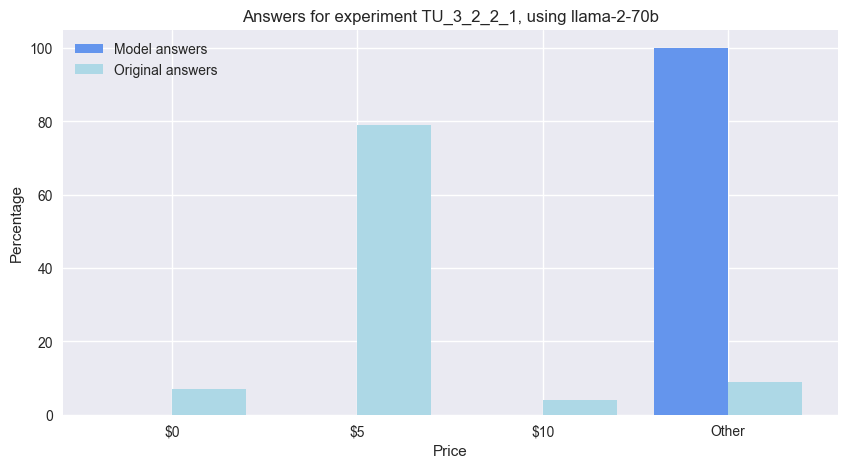

In [390]:
TU_plot_results(TU_results[(TU_results["experiment_id"] == "TU_3_2_2_1") & (TU_results["temperature"] == 0.5)])

---